## Import Libraries

In [1]:
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
age_gender = pd.read_csv('data/age_gender_bkts.csv')
countries = pd.read_csv('data/countries.csv')
users = pd.read_csv('data/train_users_2.csv')

## Sessions CSV is very large, and requires a lot of memory to read, so we read it in through chunks, and append the chunks to a list to later be used by pandas to create a dataframe.

In [3]:
session_list = []

for chunk in pd.read_csv('data/sessions.csv', chunksize=10000):
    session_list.append(chunk)
    
sessions = pd.concat(session_list)

# Begin doing very basic exploration of data, as well as seeing what values are null or missing

## Sessions

In [4]:
sessions.head(1)

sessions = sessions.dropna(how='any')

In [5]:
sessions.isnull().any()

user_id          False
action           False
action_type      False
action_detail    False
device_type      False
secs_elapsed     False
dtype: bool

## Age/Gender Country Buckets

In [6]:
age_gender.head(1)

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0


In [7]:
age_gender.isnull().any()

age_bucket                 False
country_destination        False
gender                     False
population_in_thousands    False
year                       False
dtype: bool

## Countries

In [8]:
countries.head(1)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.27516,15297.744,7741220.0,eng,0.0


In [9]:
countries.isnull().any()

country_destination              False
lat_destination                  False
lng_destination                  False
distance_km                      False
destination_km2                  False
destination_language             False
language_levenshtein_distance    False
dtype: bool

## Users

In [10]:
users = users.loc[users['country_destination'] != 'NDF']
# 88908

avg_age = math.ceil(users['age'].mean())

def avgAge(row):
    if row['age'] > 120:
        return avg_age
    else:
        return row['age']

users['age'] = users.apply(lambda x: avgAge(x), axis=1)
users['age'].fillna(avg_age, inplace=True)
users['first_affiliate_tracked'].fillna('untracked', inplace=True)

In [11]:
users.isnull().any()

id                         False
date_account_created       False
timestamp_first_active     False
date_first_booking         False
gender                     False
age                        False
signup_method              False
signup_flow                False
language                   False
affiliate_channel          False
affiliate_provider         False
first_affiliate_tracked    False
signup_app                 False
first_device_type          False
first_browser              False
country_destination        False
dtype: bool

# There are several missing values in all the dataframes
* ### Sessions - User ID, Action, Action Type, Action Detail, Seconds Elapsed
* ### Users - Date First Booking, Age, Gender, First Affiliate Tracked, First Browser

# Best way to solve for them
* For sessions, dropping all rows with a null value only drops it down from 10 milliion to 9 million, so although it is a large number of rows, relative to the data frame its in, it is not significant

* For user without a first booking, their country destination is also NDF, which means 'No Destination Found' which says that they never booked any trips. Since this information is not important to me to help make predictions on what country a user will actually travel too, I will also drop all rows where the country_destination is 'NDF'. For any missing values of first booking left over where there is a destination the user traveled to, it can be assumed that there first booking will be somewhat close to when their account is created. Because of this I will map through the users making their first booking date the date of their account creation. 
    * This brings it down a considerable amount, more than 50%, which is troublesome, but until a better way is discovered it will have to do.
* For users.Age, I will just use the mean of all user ages.
* First affiliate tracked in the users table already has an 'untracked' category, so for any NaN values, I will replace it with 'untracked'
* For gender, I will have to keep the 'unknown' category as 'unknown' since gender is probably a very important feature for prediction.

In [12]:
other_dict = {
    'country_destination': 'other', 
    'lat_destination': countries['lat_destination'].mean(),
    'lng_destination': countries['lng_destination'].mean(),
    'distance_km': countries['distance_km'].mean(),
    'destination_km2': countries['destination_km2'].mean(),
    'destination_language ': countries['destination_language '].iloc[0],
    'language_levenshtein_distance': countries['language_levenshtein_distance'].mean()
}

countries = countries.append(other_dict, ignore_index=True)

### User and Session data frames can be joined by a user id
* Could gather useful nformation such as what users spend the most time on in the AirBnB site, or what they do the most frequently on the site.

### User and Country can be joined by country_destination
* Good for looking at size and main language of country destination

### User and Age_Gender_Bkts can be joined on gender/country_dest/modified age
* This may be useful in getting the total population of the country they are headed to, or the population of the age/group they are in. Maybe even girl to guy ratio of age group they are in, or ratio of age group compared to entire population they are in.

In [13]:
user_and_country = pd.merge(users, countries, how='outer', on='country_destination')
user_and_country['gender'] = user_and_country['gender'].str.lower()
user_and_country = user_and_country.loc[user_and_country['gender'] != 'OTHER']

def convertUnknown(row):
    if row['first_browser'] == '-unknown-':
        return 'Other'
    else:
        return row['first_browser']

user_and_country['first_browser'] = user_and_country.apply(lambda x: convertUnknown(x), axis=1)
user_and_country['first_browser'] = user_and_country['first_browser'].astype('category')
user_and_country = user_and_country.drop('language_levenshtein_distance', axis=1)

## Make age range string in age_gender_buckets table an actual list to assist with merging that dataframe with user_and_country dataframe

In [14]:
def getAgeList(row):
    clean_age = row['age_bucket'].replace('+', '')
    min_max = clean_age.split('-')
    
    if len(min_max) > 1:
        min_max = list(range(int(min_max[0]), int(min_max[1]) + 1))
    return min_max

age_gender['age_list'] = age_gender.apply(lambda x: getAgeList(x), axis=1)

In [15]:
l = age_gender['age_list'].str.len()
cols = age_gender.columns.difference(['age_list'])

df = pd.DataFrame({col: np.repeat(age_gender[col].values, l) for col in cols})
df['age'] = np.concatenate(age_gender['age_list'].values).astype(int)

user_country_buckets = pd.merge(df, user_and_country, how="inner", on=['age', 'country_destination', 'gender'])
user_country_buckets = user_country_buckets.drop('age_bucket', axis=1)
user_country_buckets = user_country_buckets.drop('year', axis=1)

user_country_buckets = user_country_buckets.rename(columns={'population_in_thousands': 'dest_age_pop'})
user_country_buckets['dest_age_pop'] = user_country_buckets['dest_age_pop'].apply(lambda x: math.ceil(x*1000))

# Thinking of way to use session data

In [16]:
x = sessions.groupby('user_id')['action_detail'].value_counts()

In [17]:
x.head(15)

user_id     action_detail              
00023iyk9l  p3                              6
            p5                              5
            view_search_results             5
            dashboard                       4
            wishlist_content_update         4
            similar_listings                3
            change_trip_characteristics     2
            header_userpic                  2
            your_trips                      2
            confirm_email_link              1
            pending                         1
0010k6l0om  p3                             13
            view_search_results            10
            change_trip_characteristics     8
            wishlist_content_update         8
Name: action_detail, dtype: int64

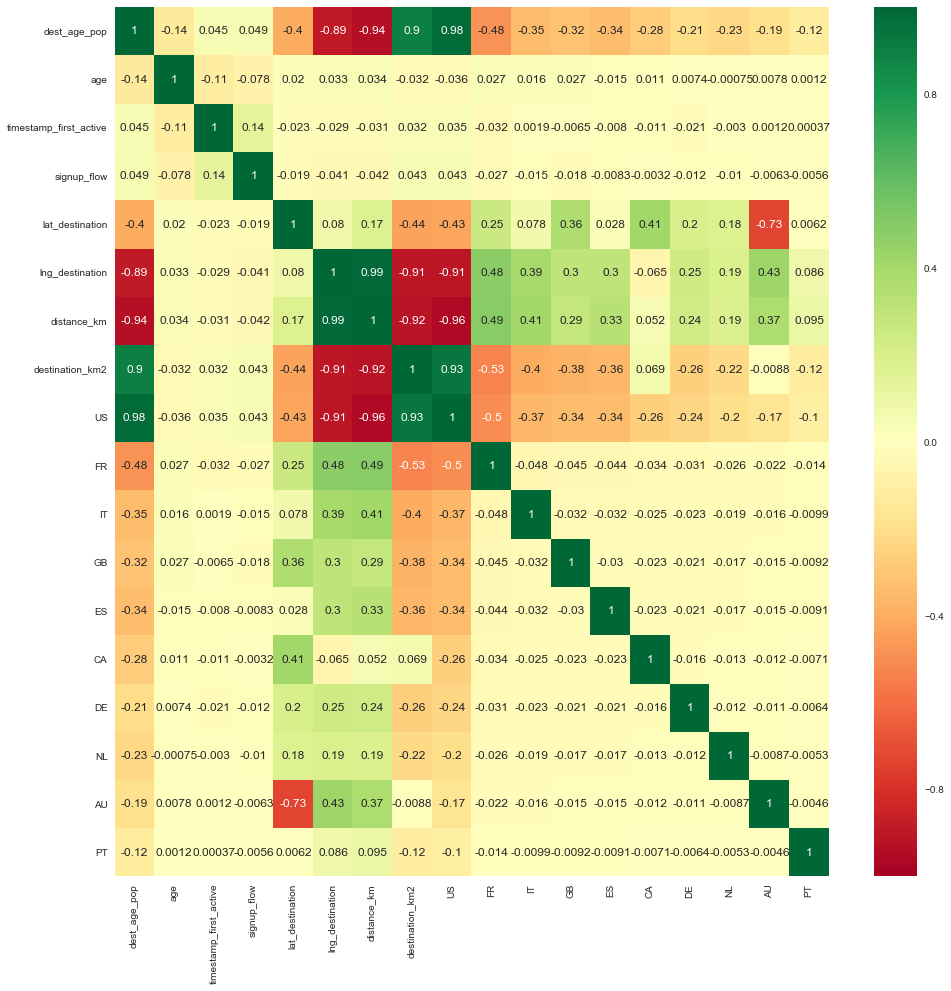

,country_destination,gender,dest_age_pop,age,id,date_account_created,timestamp_first_active,date_first_booking,signup_method,signup_flow,...,US,FR,IT,GB,ES,CA,DE,NL,AU,PT
0,AU,male,415000,71,e2jv79axh0,2014-01-13,20140113191425,2014-01-13,basic,0,...,0,0,0,0,0,0,0,0,1,0
1,AU,male,415000,73,5uzn5yqyz6,2012-10-21,20121021012712,2012-10-21,facebook,12,...,0,0,0,0,0,0,0,0,1,0
2,AU,male,574000,68,1xc8hpc77c,2013-10-08,20131008180536,2013-10-09,basic,0,...,0,0,0,0,0,0,0,0,1,0
3,AU,male,574000,69,6v9qw4yev2,2014-02-03,20140203180026,2014-02-04,facebook,0,...,0,0,0,0,0,0,0,0,1,0
4,AU,male,636000,62,ewv7zn4r7k,2014-03-01,20140301172819,2014-03-12,facebook,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
country_list = ['US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT']
row_count = ucb.shape[0]

empty_array = np.zeros(row_count)
ucb['US'] = empty_array
ucb['FR'] = empty_array
ucb['IT'] = empty_array
ucb['GB'] = empty_array
ucb['ES'] = empty_array
ucb['CA'] = empty_array
ucb['DE'] = empty_array
ucb['NL'] = empty_array
ucb['AU'] = empty_array
ucb['PT'] = empty_array
ucb.head(2)

def fillCountry(row, country):
    if row['country_destination'] == country:
        return 1
    else:
        return 0

ucb['US'] = ucb.apply(lambda x: fillCountry(x, 'US'), axis=1)
ucb['FR'] = ucb.apply(lambda x: fillCountry(x, 'FR'), axis=1)
ucb['IT'] = ucb.apply(lambda x: fillCountry(x, 'IT'), axis=1)
ucb['GB'] = ucb.apply(lambda x: fillCountry(x, 'GB'), axis=1)
ucb['ES'] = ucb.apply(lambda x: fillCountry(x, 'ES'), axis=1)
ucb['CA'] = ucb.apply(lambda x: fillCountry(x, 'CA'), axis=1)
ucb['DE'] = ucb.apply(lambda x: fillCountry(x, 'DE'), axis=1)
ucb['NL'] = ucb.apply(lambda x: fillCountry(x, 'NL'), axis=1)
ucb['AU'] = ucb.apply(lambda x: fillCountry(x, 'AU'), axis=1)
ucb['PT'] = ucb.apply(lambda x: fillCountry(x, 'PT'), axis=1)

ucb['gender'] = ucb['gender'].astype('category')

corr = ucb.corr()
sns.heatmap(corr, annot=True, cbar=True, cmap='RdYlGn')
plt.show()

ucb.head(5)
# Gender, Signup Method, language, affiliate channel, affiliate provider first_affiliate tracked, signup_app
# first device type, first browser, dest_lang

# There is literally no correlation between the country traveled to, and anything not relating to the country itself like size -.-

# Start looking at comparisons between categorical data, and country_destination

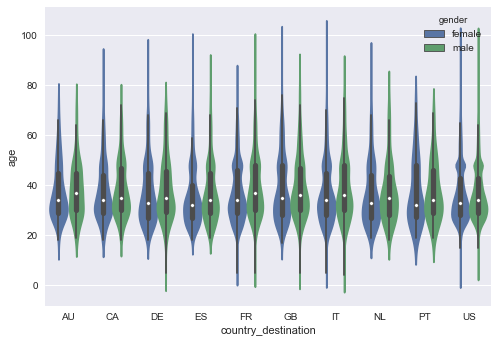

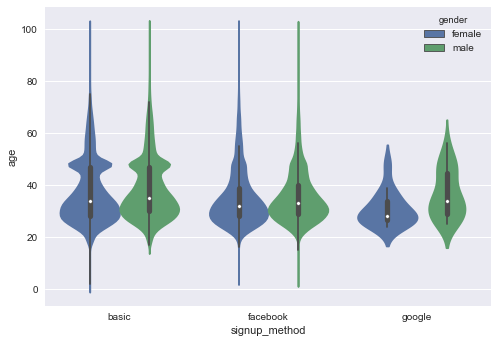

In [20]:
# Color code different violin plots per gender and age for age
sns.violinplot('country_destination', 'age', data=ucb, hue='gender')
plt.show()

sns.violinplot('signup_method', 'age', data=ucb, hue='gender')
plt.show()

In [21]:
ucb.to_csv('clean_airbnb.csv', index=False)